In [1]:
from transformers import AutoTokenizer, AutoModel

# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
model = AutoModel.from_pretrained('allenai/specter')

D:\Chrome_Dwnld\anaconda\envs\IML_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import tqdm
import pandas as pd
# we can use a persistent dictionary (via shelve) so we can stop and restart if needed
# alternatively, do the same but with embeddings starting as an empty dictionary
embeddings = {}
papers=pd.read_json('./data/Alzheimer.json')
for pmid, paper in tqdm.tqdm(papers.items()):
 data = [paper["ArticleTitle"] + tokenizer.sep_token + paper['AbstractText']]
 inputs = tokenizer(
 data, padding=True, truncation=True, return_tensors="pt", max_length=512
 )
 result = model(**inputs)
 # take the first token in the batch as the embedding
 embeddings[pmid] = result.last_hidden_state[:, 0, :].detach().numpy()[0]
# turn our dictionary into a list
embeddings = [embeddings[pmid] for pmid in papers.keys()]

1000it [10:20,  1.61it/s]


In [4]:
print(type(embeddings))
print(len(embeddings),len(embeddings[0]))

<class 'list'>
1000 768


In [8]:
embeddings2 = {}
papers=pd.read_json('./data/cancer.json')
for pmid, paper in tqdm.tqdm(papers.items()):
 data = [paper["ArticleTitle"] + tokenizer.sep_token + paper['AbstractText']]
 inputs = tokenizer(
 data, padding=True, truncation=True, return_tensors="pt", max_length=512
 )
 result = model(**inputs)
 # take the first token in the batch as the embedding
 embeddings2[pmid] = result.last_hidden_state[:, 0, :].detach().numpy()[0]
# turn our dictionary into a list
embeddings2 = [embeddings2[pmid] for pmid in papers.keys()]

1000it [09:22,  1.78it/s]


In [10]:
import numpy as np
embeddings_total=np.concatenate((embeddings,embeddings2))
print(embeddings_total.shape)

(2000, 768)


In [11]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
embeddings_pca = pd.DataFrame(
 pca.fit_transform(embeddings_total),
 columns=['PC0', 'PC1', 'PC2']
)
query_list=['Alzheimer']*1000+['cancer']*1000
embeddings_pca["query"] = query_list

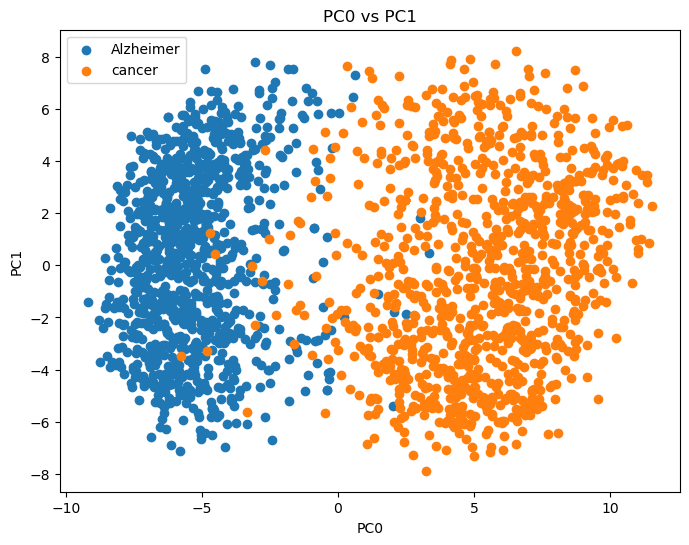

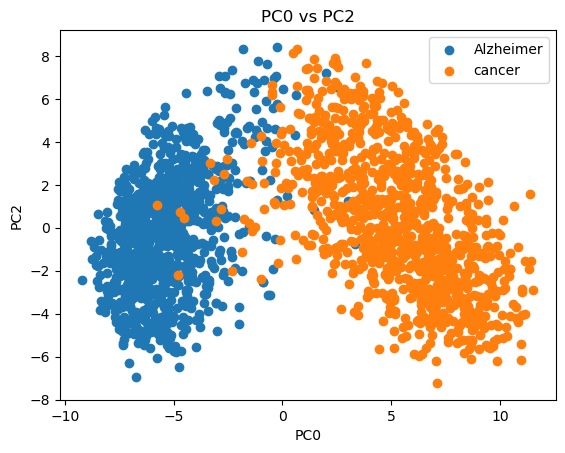

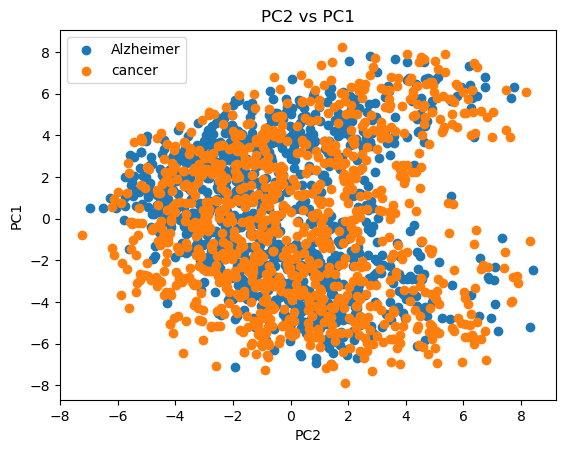

In [14]:
import matplotlib.pyplot as plt
PC0=embeddings_pca['PC0']
PC1=embeddings_pca['PC1']
PC2=embeddings_pca['PC2']
plt.figure(figsize=(8, 6))
for c in np.unique(query_list):
    i = np.where(np.array(embeddings_pca['query'])==c)
    plt.scatter(np.array(PC0)[i], np.array(PC1)[i], label=c)
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title('PC0 vs PC1')
plt.legend()
plt.savefig('PC0-1.png')
plt.show()

for c in np.unique(query_list):
    i = np.where(np.array(embeddings_pca['query'])==c)
    plt.scatter(np.array(PC0)[i], np.array(PC2)[i], label=c)
plt.xlabel('PC0')
plt.ylabel('PC2')
plt.title('PC0 vs PC2')
plt.legend()
plt.savefig('PC0-2.png')
plt.show()

for c in np.unique(query_list):
    i = np.where(np.array(embeddings_pca['query'])==c)
    plt.scatter(np.array(PC2)[i], np.array(PC1)[i], label=c)
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.title('PC2 vs PC1')
plt.legend()
plt.savefig('PC2-1.png')
plt.show()

In [15]:
print(pca.explained_variance_ratio_)

[0.16913469 0.06433377 0.04573277]
